# Определение перспективного тарифа для телеком-компании

**Цель:** Определить выгодный тарифный план для корректировки рекламного бюджета.

**Выборка:** Данные 500 пользователей тарифных планов «Смарт» и «Ультра»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Примечание:** «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт:

Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных
### Таблица users (информация о пользователях):
* **user_id** — уникальный идентификатор пользователя
* **first_name** — имя пользователя
* **last_name** — фамилия пользователя
* **age** — возраст пользователя (годы)
* **reg_date** — дата подключения тарифа (день, месяц, год)
* **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* **city** — город проживания пользователя
* **tariff** — название тарифного плана
### Таблица calls (информация о звонках):
* **id** — уникальный номер звонка
* **call_date** — дата звонка
* **duration** — длительность звонка в минутах
* **user_id** — идентификатор пользователя, сделавшего звонок
### Таблица messages (информация о сообщениях):
* **id** — уникальный номер сообщения
* **message_date** — дата сообщения
* **user_id** — идентификатор пользователя, отправившего сообщение
### Таблица internet (информация об интернет-сессиях):
* **id** — уникальный номер сессии
* **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
* **session_date** — дата интернет-сессии
* **user_id** — идентификатор пользователя
### Таблица tariffs (информация о тарифах):
* **tariff_name** — название тарифа
* **rub_monthly_fee** — ежемесячная абонентская плата в рублях
* **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
* **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
* **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
* **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# импорт библиотек 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
# чтение файлов
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Открытие файлов. Изучение общей информации

<a id='intro'></a>

### Таблица calls

In [3]:
print(calls.head(15)) # получение первых 15 строк датафрейма
print('')
print(calls.info()) # получение общей информации
print('')
print('количество пропущенных значений:', calls.isna().sum())
print('')
print('количество дубликатов:', calls.duplicated().sum())
print('')
print('число строк и столбцов:', calls.shape)
print()
print(calls['call_date'].describe())
print(calls['duration'].describe());

         id   call_date  duration  user_id
0    1000_0  2018-07-25      0.00     1000
1    1000_1  2018-08-17      0.00     1000
2    1000_2  2018-06-11      2.85     1000
3    1000_3  2018-09-21     13.80     1000
4    1000_4  2018-12-15      5.18     1000
5    1000_5  2018-11-02      0.00     1000
6    1000_6  2018-10-18      0.00     1000
7    1000_7  2018-08-22     18.31     1000
8    1000_8  2018-09-15     18.44     1000
9    1000_9  2018-08-15      0.00     1000
10  1000_10  2018-08-22      5.03     1000
11  1000_11  2018-05-28     18.82     1000
12  1000_12  2018-07-05      2.02     1000
13  1000_13  2018-09-29      7.15     1000
14  1000_14  2018-12-11      9.13     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  floa

**Вывод:** аномальных значений не выявлено, дубликатов и пропусков нет. период изучения данных 1 год: с первого января 2018 года по 31 декабря 2018. Необходимо перевести тип данных столбца call_date (дата звонка) из object в datetime64.
В данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять. «Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округлим в большую сторону до минуты все звонки при помощи np.ceil:

In [4]:
calls['duration'] = np.ceil(calls['duration']) # применение метода
calls['duration'] = calls['duration'].astype(int) # изменение типа данных в целочисленный
calls.head()  # проверка метода

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'],  format='%Y-%m-%d') # приведение к типу даты
print(calls.info()) # проверка метода

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB
None


В дальнейшем все расчеты будут происходить помесячно. Поэтому добавлю столбец с месяцем в необходимые таблицы

In [6]:
calls['month'] = calls['call_date'].dt.month # добавление столбца месяц
calls.head()  # проверка метода

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


### internet

In [7]:
print(internet.head(15))
print()
print(internet.info())
print()
print('количество пропущенных значений:', internet.isna().sum())
print('количество дубликатов:', internet.duplicated().sum())
print('число строк и столбцов:', internet.shape)
print(internet.describe())
print()
print(internet['session_date'].describe());

    Unnamed: 0       id  mb_used session_date  user_id
0            0   1000_0   112.95   2018-11-25     1000
1            1   1000_1  1052.81   2018-09-07     1000
2            2   1000_2  1197.26   2018-06-25     1000
3            3   1000_3   550.27   2018-08-22     1000
4            4   1000_4   302.56   2018-09-24     1000
5            5   1000_5   399.97   2018-10-02     1000
6            6   1000_6   540.08   2018-09-07     1000
7            7   1000_7   415.70   2018-07-11     1000
8            8   1000_8   505.40   2018-10-08     1000
9            9   1000_9   345.54   2018-09-03     1000
10          10  1000_10   385.14   2018-09-27     1000
11          11  1000_11     0.00   2018-08-28     1000
12          12  1000_12   375.87   2018-06-20     1000
13          13  1000_13   393.83   2018-08-09     1000
14          14  1000_14   180.64   2018-08-11     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Colu

**Вывод:** аномальных значений не выявлено, дубликатов и пропусков нет. период изучения данных 1 год: с первого января 2018 года по 31 декабря 2018. Переведем тип данных столбца session_date (дата интернет-сессии) из object в datetime64 и добавим столбец с месяцем

In [8]:
internet['session_date'] = pd.to_datetime(internet['session_date'],  format='%Y-%m-%d') # приведение к типу даты

internet['month'] = internet['session_date'].dt.month #добавление столбца месяц
internet.info() # проверка методов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


### messages

In [9]:
print(messages.head(15))
print()
print(messages.info())
print()
print('количество пропущенных значений:', messages.isna().sum())
print('количество дубликатов:', messages.duplicated().sum())
print('число строк и столбцов:', messages.shape)
print()
print(messages['message_date'].describe());

         id message_date  user_id
0    1000_0   2018-06-27     1000
1    1000_1   2018-10-08     1000
2    1000_2   2018-08-04     1000
3    1000_3   2018-06-16     1000
4    1000_4   2018-12-05     1000
5    1000_5   2018-06-20     1000
6    1000_6   2018-11-19     1000
7    1000_7   2018-10-29     1000
8    1000_8   2018-06-25     1000
9    1000_9   2018-12-18     1000
10  1000_10   2018-05-30     1000
11  1000_11   2018-07-06     1000
12  1000_12   2018-08-20     1000
13  1000_13   2018-10-30     1000
14  1000_14   2018-09-14     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

количество пропущенных значений: id              0
message_date    0
user_

**Вывод:** аномальных значений не выявлено, дубликатов и пропусков нет. Переведем тип данных столбца message_date (дата сообщения) из object в datetime64. Добавим столбец с месяцем

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'],  format='%Y-%m-%d') # приведение к типу даты

messages['month'] = messages['message_date'].dt.month #добавление столбца месяц
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


### users

In [11]:
print(users.head(15))
print()
print(users.info())
print()
print('количество пропущенных значений:', users.isna().sum())
print('количество дубликатов:', users.duplicated().sum())
print('число строк и столбцов:', users.shape)
print(users.describe())
print()
print(users['reg_date'].describe())
print()
print(users['churn_date'].describe());

    user_id  age churn_date              city first_name  last_name  \
0      1000   52        NaN         Краснодар     Рафаил  Верещагин   
1      1001   41        NaN            Москва       Иван       Ежов   
2      1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3      1003   23        NaN            Москва      Белла   Белякова   
4      1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5      1005   67        NaN  Набережные Челны   Афанасий     Горлов   
6      1006   21        NaN         Ульяновск     Леонид   Ермолаев   
7      1007   65        NaN            Москва        Юна   Березина   
8      1008   63        NaN         Челябинск     Рустэм  Пономарёв   
9      1009   24        NaN             Пермь   Василиса    Блинова   
10     1010   26        NaN            Тюмень     Эдуард    Кононов   
11     1011   44        NaN            Самара   Веселина     Алёшко   
12     1012   38        NaN   Санкт-Петербург     Варлам   Соловьев   
13    

**Вывод:** аномальных значений не выявлено, явных дубликатов нет. Пропущенные значения в столбце churn_date связана с тем, что пользователь все еще подключен к данному тарифу. максимальный возраст пользователя 75 лет, минимальный 18. Переведем тип данных столбцов reg_date и churn_date из object в datetime. Посмотрим сколько пользователь подключены к тарифу на момент исследования:

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'],  format='%Y-%m-%d') 
users['churn_date'] = pd.to_datetime(users['churn_date'],  format='%Y-%m-%d') # приведение к типу даты
print(users.info()) # проверка метода

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


### tariffs

**Описание тарифов**

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено: 
    - 500 минут разговора
    - 50 сообщений 
    - 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено: 
    - 3000 минут разговора
    - 1000 сообщений 
    - 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль 
    - сообщение: 1 рубль 
    - 1 Гб интернет-трафика: 150 рублей
    
**Примечание**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

In [13]:
print(tariffs)
print()
print(tariffs.info())
print()
print('количество пропущенных значений:', tariffs.isna().sum())
print('количество дубликатов:', tariffs.duplicated().sum())
print('число строк и столбцов:', tariffs.shape);

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tarif

**Вывод:** аномальных значений не выявлено, дубликатов и пропусков нет. Таблица описывает тарифы смарт и ультра и цены на них

## Подготовка данных

<a id='intro2'></a>

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [14]:
# создадим словарь, который будет содержать информацию о соответствии тарифа пользователю
tarif_for_user = {}

# напишем функцию для заполнения словаря
def add_tarif_to_user(row):
    tarif_for_user[row[0]] = row[7]
    
# применим функцию
users.apply(add_tarif_to_user, axis=1)
len(tarif_for_user)

500

In [15]:
# Посмотрим на распределения пользователей по тарифам:
print('Количество пользователей тарифа smart:', len(users.query('tariff == "smart"')))
print('Количество пользователей тарифа ultra:', len(users.query('tariff == "ultra"')))

Количество пользователей тарифа smart: 351
Количество пользователей тарифа ultra: 149


Получили словарь, в котором сопоставлены user_id и tariff. Добавим колонки с тарифами к calls, internet и messages.

In [16]:
# функция для добавления тарифа
def add_tariff(row):
    return tarif_for_user[row]

for i in (calls, internet, messages):
    i['tariff'] = i['user_id'].apply(add_tariff)

In [17]:
# расчет звонков по месяцам для каждого пользователя

calls_pivot = calls.pivot_table(index=['user_id', 'tariff', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_pivot.columns = ['minutes_calls', 'count_calls']
calls_pivot.head(10)

minutes_calls  count_calls
user_id tariff month                            
1000    ultra  5                159           22
               6                172           43
               7                340           47
               8                408           52
               9                466           58
               10               350           57
               11               338           43
               12               333           46
1001    smart  11               430           59
               12               414           63

In [18]:
# расчет сообщений по месяцам для каждого пользователя

messages_pivot = messages.pivot_table(index=['user_id', 'tariff', 'month'], values='id', aggfunc=['count'])
messages_pivot.columns = ['count_messages']
messages_pivot.head(10)

count_messages
user_id tariff month                
1000    ultra  5                  22
               6                  60
               7                  75
               8                  81
               9                  57
               10                 73
               11                 58
               12                 70
1002    smart  6                   4
               7                  11

In [19]:
# расчет интернет-трафика по месяцам для каждого пользователя
internet_pivot = internet.pivot_table(index=['user_id', 'tariff', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['mb_used']
internet_pivot.head(10)

mb_used
user_id tariff month          
1000    ultra  5       2253.49
               6      23233.77
               7      14003.64
               8      14055.93
               9      14568.91
               10     14702.49
               11     14756.47
               12      9817.61
1001    smart  11     18429.34
               12     14036.66

Чтобы расчитать помесячную выручку с каждого пользователя составлю таблицу, в которой указана вся необходимая информация о пользователе: тариф, потраченные минуты звонков, смс, интернет:

In [20]:
data_merge = users.merge(calls_pivot.reset_index(), 
                         how='outer').merge(internet_pivot.reset_index(), 
                                           how='outer').merge(messages_pivot.reset_index(), 
                                                             how='outer')
# обзор получившейся таблицы
display(data_merge.head())
data_merge.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,mb_used,count_messages
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,2253.49,22.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23233.77,60.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14003.64,75.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14055.93,81.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,14568.91,57.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3222 non-null   int64         
 1   age             3182 non-null   float64       
 2   churn_date      189 non-null    datetime64[ns]
 3   city            3182 non-null   object        
 4   first_name      3182 non-null   object        
 5   last_name       3182 non-null   object        
 6   reg_date        3182 non-null   datetime64[ns]
 7   tariff          3222 non-null   object        
 8   month           3214 non-null   float64       
 9   minutes_calls   3174 non-null   float64       
 10  count_calls     3174 non-null   float64       
 11  mb_used         3203 non-null   float64       
 12  count_messages  2717 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1), object(4)
memory usage: 352.4+ KB


В даных обнаружены пропуски. Но если для столбца churn_date пропуски оправданны, то пропуски в month могут повлиять на вычисления. Если в ячейке есть nan, значит абонент не пользовался предоставленной связью. Заполним nan нулями. Уберем из таблицы данные со значением месяца = 0. У этих записей количество минут, смс и мб также равно 0, они внесут искажения в распределения.

In [21]:
data_merge = data_merge.fillna(0)
data_merge = data_merge[data_merge['month'] != 0]
data_merge['month'] = data_merge['month'].astype(int)
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3221
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   age             3214 non-null   float64
 2   churn_date      3214 non-null   object 
 3   city            3214 non-null   object 
 4   first_name      3214 non-null   object 
 5   last_name       3214 non-null   object 
 6   reg_date        3214 non-null   object 
 7   tariff          3214 non-null   object 
 8   month           3214 non-null   int64  
 9   minutes_calls   3214 non-null   float64
 10  count_calls     3214 non-null   float64
 11  mb_used         3214 non-null   float64
 12  count_messages  3214 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 351.5+ KB


In [22]:
# Помесячная выручка с каждого пользователя:
# вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
# остаток умножим на значение из тарифного плана; прибавим абонентскую плату, 
# соответствующую тарифному плану

def megaline_income(row):    
    # произведем расчеты выручки для каждого тарифа
    # определим функцию по проверке тарифа и расчета сумм к оплате для каждого абонента
    def check(tariff):  
        # расчет количества минут к оплате
        minutes_for_pay = row[9] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 2]
        if minutes_for_pay < 0:
            minutes_for_pay = 0            
        # расчет количества мегабайт к оплате
        internet_for_pay = np.ceil((row[11] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 1]) / 1024)
        if internet_for_pay < 0:
            internet_for_pay = 0
        # расчет количества сообщений к оплате
        messages_for_pay = row[12] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 0]
        if messages_for_pay < 0:
            messages_for_pay = 0
        return sum([minutes_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 6], 
                internet_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 4], 
                messages_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 5]])
    # создадим переменную, в которую сохраним значения суммы оплаты минут, сообщений и мб сверх тарифа
    result_cash = check(row[7])
    return tariffs[tariffs['tariff_name'] == row[7]].iloc[0, 3] + result_cash

Добавим в таблицу столбец income, в котором сохранена информация о выручке с каждого пользователя

In [23]:
data_merge['income'] = data_merge.apply(megaline_income, axis=1)
data_merge.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,mb_used,count_messages,income
0,1000,52.0,0,Краснодар,Рафаил,Верещагин,2018-05-25 00:00:00,ultra,5,159.0,22.0,2253.49,22.0,1950.0
1,1000,52.0,0,Краснодар,Рафаил,Верещагин,2018-05-25 00:00:00,ultra,6,172.0,43.0,23233.77,60.0,1950.0
2,1000,52.0,0,Краснодар,Рафаил,Верещагин,2018-05-25 00:00:00,ultra,7,340.0,47.0,14003.64,75.0,1950.0
3,1000,52.0,0,Краснодар,Рафаил,Верещагин,2018-05-25 00:00:00,ultra,8,408.0,52.0,14055.93,81.0,1950.0
4,1000,52.0,0,Краснодар,Рафаил,Верещагин,2018-05-25 00:00:00,ultra,9,466.0,58.0,14568.91,57.0,1950.0


## Анализ данных
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

<a id='intro3'></a>

Сравним два тарифа за весь период исследования:

In [24]:
table = data_merge.pivot_table(index='tariff', values=['minutes_calls', 'mb_used', 'count_messages'], aggfunc=['mean', 'std', 'var'])
table.columns = ['Среднее количество сообщений',
                      'Среднее количество Мб', 
                      'Среднее количество минут разговора',
                      'Стандартное отклонение (сообщения)',
                      'Стандартное отклонение (трафик Мб)',
                      'Стандартное отклонение (звонки)',
                      'Дисперсия (сообщения)',
                      'Дисперсия (трафик Мб)',
                      'Дисперсия (звонки)']
table

,Среднее количество сообщений,Среднее количество Мб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Мб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Мб),Дисперсия (звонки)
tariff,,,,,,,,,
smart,33.384029,16208.386990,417.934948,28.227876,5870.476681,190.313730,796.812958,3.446250e+07,36219.315784
ultra,49.363452,19468.805208,526.623350,47.804457,10087.170752,317.606098,2285.266143,1.017510e+08,100873.633397


In [25]:
data_smart = data_merge.query('tariff == "smart"').pivot_table(index='month', 
                                                      values=['minutes_calls', 'mb_used', 'count_messages'],
                                                      aggfunc=['mean', 'std', 'var'])
data_smart.columns = ['Среднее количество сообщений',
                      'Среднее количество Мб', 
                      'Среднее количество минут разговора',
                      'Стандартное отклонение (сообщения)',
                      'Стандартное отклонение (трафик Мб)',
                      'Стандартное отклонение (звонки)',
                      'Дисперсия (сообщения)',
                      'Дисперсия (трафик Мб)',
                      'Дисперсия (звонки)']
data_smart

,Среднее количество сообщений,Среднее количество Мб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Мб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Мб),Дисперсия (звонки)
month,,,,,,,,,
1,18.235294,8513.717647,203.852941,16.197753,6444.681014,154.231454,262.367201,4.153391e+07,23787.341355
2,24.086207,11597.054310,298.689655,21.750809,6247.353833,190.820041,473.097701,3.902943e+07,36412.287961
3,31.857143,15104.159091,390.051948,26.804710,5828.237537,191.893604,718.492481,3.396835e+07,36823.155161
4,30.741071,13462.180625,367.133929,24.538532,5698.249092,186.489161,602.139559,3.247004e+07,34778.207127
5,33.773050,15805.184326,387.361702,27.036845,5978.231725,186.601343,730.990983,3.573925e+07,34820.061094
6,33.402439,15794.647988,395.640244,28.404337,5791.155586,175.336587,806.806374,3.353748e+07,30742.918861
7,33.751244,15743.150348,408.353234,28.282288,5897.154446,179.583601,799.887811,3.477643e+07,32250.269602
8,33.638298,16610.720085,421.468085,28.952677,5593.499133,186.530382,838.257501,3.128723e+07,34793.583379
9,33.638462,16303.578808,428.611538,28.117927,5196.115749,183.126576,790.617820,2.699962e+07,33535.342723


In [26]:
data_ultra = data_merge.query('tariff == "ultra"').pivot_table(index='month', 
                                                      values=['minutes_calls', 'mb_used', 'count_messages'],
                                                      aggfunc=['mean', 'std', 'var'])
data_ultra.columns = ['Среднее количество сообщений',
                      'Среднее количество Мб', 
                      'Среднее количество минут разговора',
                      'Стандартное отклонение (сообщения)',
                      'Стандартное отклонение (трафик Мб)',
                      'Стандартное отклонение (звонки)',
                      'Дисперсия (сообщения)',
                      'Дисперсия (трафик Мб)',
                      'Дисперсия (звонки)']
data_ultra

,Среднее количество сообщений,Среднее количество Мб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Мб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Мб),Дисперсия (звонки)
month,,,,,,,,,
1,33.777778,13140.681111,428.111111,30.670742,6865.346875,269.757968,940.694444,4.713299e+07,72769.361111
2,21.958333,11775.937500,297.125000,26.773574,10644.643911,296.512528,716.824275,1.133084e+08,87919.679348
3,32.297297,17535.550270,489.648649,41.621886,10951.785885,333.743765,1732.381381,1.199416e+08,111384.900901
4,31.563636,16828.134364,458.018182,37.513831,9718.649845,267.682405,1407.287542,9.445215e+07,71653.870034
5,37.850746,19363.152985,510.328358,40.306874,10046.110214,289.603511,1624.644052,1.009243e+08,83870.193578
6,41.726190,18924.939286,479.702381,44.567899,9292.877495,302.549081,1986.297619,8.635757e+07,91535.946500
7,49.846154,20495.665165,545.791209,48.703621,10065.197069,307.119322,2372.042735,1.013082e+08,94322.278144
8,48.439252,19576.054673,510.775701,46.601923,10476.556411,312.980026,2171.739199,1.097582e+08,97956.496385
9,52.286957,19204.277130,539.443478,46.398874,9486.088282,325.141162,2152.855530,8.998587e+07,105716.775286


Для визуализации данных построим гистограммы:

**Гистограммы для тарифа ultra**

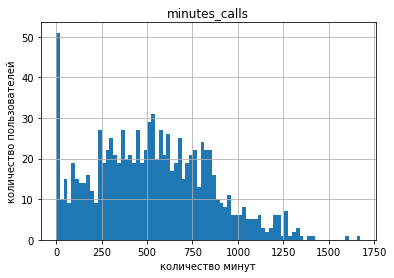

In [27]:
data_merge.query('tariff == "ultra"')['minutes_calls'].hist(bins=80)
plt.title("minutes_calls")
plt.xlabel("количество минут")
plt.ylabel("количество пользователей");

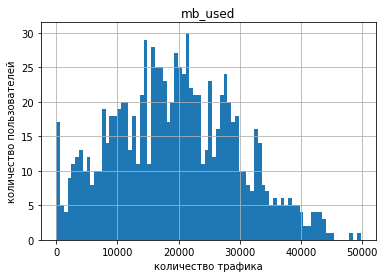

In [28]:
data_merge.query('tariff == "ultra"')['mb_used'].hist(bins=80)
plt.title("mb_used")
plt.xlabel("количество трафика")
plt.ylabel("количество пользователей");

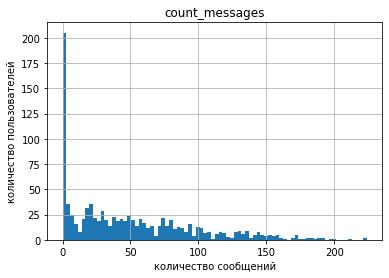

In [29]:
data_merge.query('tariff == "ultra"')['count_messages'].hist(bins=80)
plt.title("count_messages")
plt.xlabel("количество сообщений")
plt.ylabel("количество пользователей");

**Гистограммы для тарифа smart**

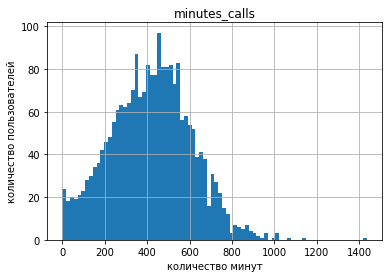

In [30]:
data_merge.query('tariff == "smart"')['minutes_calls'].hist(bins=80)
plt.title("minutes_calls")
plt.xlabel("количество минут")
plt.ylabel("количество пользователей");

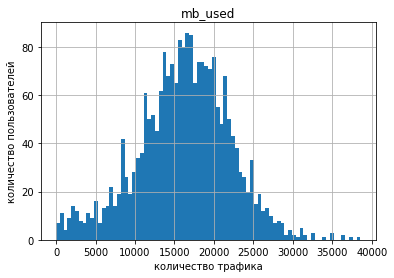

In [31]:
data_merge.query('tariff == "smart"')['mb_used'].hist(bins=80)
plt.title("mb_used")
plt.xlabel("количество трафика")
plt.ylabel("количество пользователей");

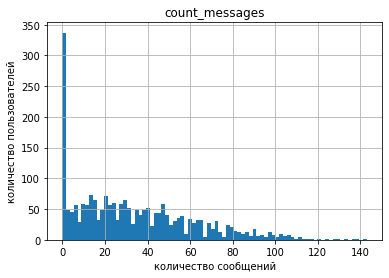

In [32]:
data_merge.query('tariff == "smart"')['count_messages'].hist(bins=80)
plt.title("count_messages")
plt.xlabel("количество сообщений")
plt.ylabel("количество пользователей");

**Вывод:**

Распределения нормальные. 

Большинство пользователей тарифа **ultra** используют:
- от 250 до 800 минут;
- от 15000 до 25000 мб;
- от 0 до 75 сообщений в месяц

Большинство пользователей тарифа **smart** используют:
- от 350 до 550 минут;
- от 12500 до 22500 мб;
- от 0 до 60 сообщений в месяц

Посмотрим на распределения выручки по каждому тарифу на графике:

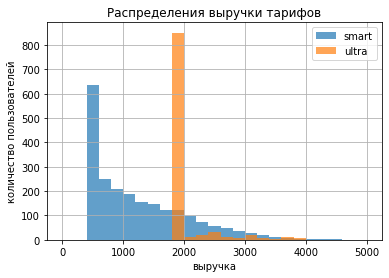

In [33]:
data_merge.query('tariff == "smart"')['income'].plot(
    kind='hist',
    range=(0, 5000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='smart',
    grid=True,
    legend=True,
) 
data_merge.query('tariff == "ultra"')['income'].plot(
    kind='hist',
    range=(0, 5000),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    grid=True,
    legend=True,
    title='Распределения выручки тарифов',
)
plt.xlabel("выручка")
plt.ylabel("количество пользователей");

**Вывод:**

Большинство пользователей тарифа **ultra** платят фиксированную абоненскую плату 1950 рублей в месяц и не выходят за рамки своего тарифа. 

В тарифе **smart** пользователи довольно часто выходят за рамки тарифа и платят сверх абоненской платы

## Проверка гипотез

<a id='intro4'></a>

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Нулевая гипотеза** - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

**Альтернативная гипотеза** - средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

Для проверки гипотезы используем `scipy.stats.ttest_ind`, так как имеем две независимые генеральные совокупности.

In [34]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
result = st.ttest_ind(data_merge[data_merge['tariff'] == 'smart']['income'], 
                      data_merge[data_merge['tariff'] == 'ultra']['income'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


**Вывод:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Нулевая гипотеза** - средняя выручка пользователей из Москвы и пользователей из других регионов равна.

**Альтернативная гипотеза** - средняя выручка пользователей из Москвы и пользователей из других регионов различны.

Для проверки гипотезы используем `st.ttest_ind`, так как имеем две независимые генеральные совокупности.

In [35]:
result = st.ttest_ind(data_merge.query('city == "Москва"')['income'], 
                      data_merge.query('city != "Москва"')['income'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.559612503546864
Не получилось отвергнуть нулевую гипотезу


**Вывод:** мы не можем отвергнуть нулевую гипотезу и исключить вероятность, что средняя выручка пользователей из Москвы и пользователей из других регионов равна

### Лучший тариф

Посмотрим на результаты пункта 5.1, которые говорят о том, что средние выручки не равны. Для ответа на главный вопрос **какой тариф лучше**, а точнее прносит больше денег компании, сравним средние выручки:

In [36]:
print('средняя выручка тарифа smart:', data_merge.query('tariff == "smart"')['income'].mean())
print('средняя выручка тарифа ultra:', data_merge.query('tariff == "ultra"')['income'].mean())

средняя выручка тарифа smart: 1289.9735307312696
средняя выручка тарифа ultra: 2070.1522842639592


Очевидно, что тариф ultra принсит больше выручки, а значит он лучше.

## Общий вывод

В данном проекте я анализировала поведение клиентов и решала задачу **какой тариф лучше.** Данные были предоставлены в пяти таблицах. Работа проводилась в несколько шагов:
* [обзор данных](#intro)
* [подготовка данных](#intro2)
    - создала словарь для тарифов, которые соответствуют каждому пользователю
    - создала несколько сводных таблиц
    - заполнила и удалила пропуски
    - расчитала выручку для каждого пользователя
* [анализ данных](#intro3)
* [проверка гипотез](#intro4)

Чтобы проверить гипотезы я воспользовалась статистическими методами `scipy.stats.ttest_ind`

70 % пользователей выборки используют тариф smart, 30 % - ultra

На основе проведенного анализа и проверки гипотез, я сравнила средние выручки по тарифам. Сделан вывод, что тариф **ultra** лучше - приносит больше выручки.